# Random Forest 


## Introduction

---

- The models trained and tuned in this notebook are RandomForest Classifiers. 
- sklearn was chosen as a library because of ease of use.
- Mean imputing and one-hot-encoding for categorical variables were used in data preprocessing.
- PCA was done to reduce dimensionality.
- Weights were added to deal with class imbalance, and balanced log loss and auc were chosen as evaluation metrics to deal with class imbalance as well.  
- GridSearchCV was selected for hyperparameter tuning, and the parameters which were fine-tuned were n_estimators (Number of trees in the forest) and max_depth (maximum depth of decision tree)
- This model was discarded, because it was generating a negative balanced log loss and overfittig, for reasons unknown, so we switched methodologies for dealing with class imbalance, as mentioned in the notebook `RF_downsampling.ipynb`

In [1]:
# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, log_loss
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from scipy.stats import randint
from sklearn.metrics import get_scorer_names
from random import randint #so that randomizedsearchcv will work
from yellowbrick.model_selection import ValidationCurve


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import warnings
warnings.filterwarnings('ignore')


## Data loading and preprocessing
---

In [2]:
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/')
dataset = pd.read_csv('train.csv')

In [3]:
# Change label to integer 
label = "Class"

classes = dataset[label].unique().tolist()
print(f"Label classes: {classes}")

dataset[label] = dataset[label].map(classes.index)

Label classes: [1, 0]


In [4]:
#convert EJ to dummy for PCA
ej_dummy = pd.get_dummies(
    dataset['EJ'],prefix='EJ', dtype=int)

dataset = pd.concat(
    [dataset,ej_dummy],
    axis=1
)

#drop ID and EJ
dataset = dataset.drop(['Id','EJ'], axis=1)

In [5]:
# outcome 
y = dataset['Class'].values

# features 
X = dataset[[i for i in dataset.columns if i not in ['Class']]].values

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                   test_size=0.20, random_state=42)

# train and test dataframes 
train_df = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

test_df = pd.concat(
    [pd.DataFrame(y_test), pd.DataFrame(X_test)],
    axis=1
)

# rename columns
train_df.columns=['Class','AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC',
                  'BD ', 'BN', 'BP','BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF',
                  'CH', 'CL', 'CR', 'CS', 'CU','CW ', 'DA', 'DE', 'DF', 'DH',
                  'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH',
                  'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR','FS',
                  'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'EJ_A', 'EJ_B']

# assign names to test_df
test_df.columns = train_df.columns

In [6]:
# Find which columns have missing values
sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]

BQ    53
CC     1
DU     1
EL    52
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [7]:
# mean imputing on train_df
mean_values = train_df.mean()
filled_df = train_df.fillna(mean_values, inplace=False)
train_df = filled_df

sum_null = train_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

In [8]:
# mean imputing on test_df, with mean values from train_df
mean_values = train_df.mean()
filled_df = test_df.fillna(mean_values, inplace=False)
test_df = filled_df

sum_null = test_df.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

In [9]:
# Split  data set into X_train, y_train, X_test, y_test
columns = [i for i in dataset.columns if i not in ['Class']]

y_train = train_df[label].values
y_test = test_df[label].values

X_train = train_df[columns].values
X_test = test_df[columns].values


# # Check the shape of the train and test sets
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape,'\nShape y_test:', y_test.shape)

Shape X_train:  (493, 57) 
Shape X_test:  (124, 57) 
Shape y_train:  (493,) 
Shape y_test: (124,)


In [10]:
# normalize the features for PCA
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Feature Extraction using PCA

In [11]:
#include all variables in the original dataset
pca = PCA(n_components=56)  
pca.fit(X_train_std)

# Rename the columns to add "PCA" at the beginning of each principal component
columns = []
for i in range(pca.n_components):
    columns.append('PCA{}'.format(i + 1))

Number of principal components explaining 95% of variance: 39


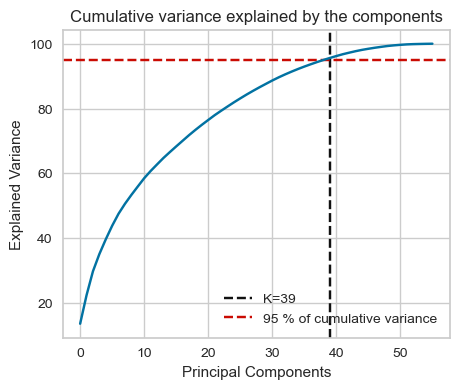

In [12]:
# Check how many components are actually needed for out model, by looking at the cumulative variance
var_cum = np.cumsum(pca.explained_variance_ratio_)*100
 
# number of principal components thet explain 95% of the variance 
# (code taken and adapted from Dr. Ilin's week 8 live session notebook: "dimensionality reduction")

k = np.argmax(var_cum>95)
print("Number of principal components explaining 95% of variance: "+ str(k))
 
plt.figure(figsize=[5,4])
plt.title('Cumulative variance explained by the components')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.axvline(x=k, color="k", linestyle="--", label = "K=39")
plt.axhline(y=95, color="r", linestyle="--", label="95 % of cumulative variance")
ax = plt.plot(var_cum)
              
plt.legend()

In [12]:
# rerun again with 39 components
pca = PCA(n_components=39) 
pca.fit(X_train)

# Rename the columns
columns = []
for i in range(pca.n_components):
    columns.append('PCA{}'.format(i + 1))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
# remake train and test dfs with pcas
train_df_pca = pd.concat(
    [pd.DataFrame(X_train_pca, columns=columns),pd.DataFrame(y_train, columns=['Class'])],
    axis=1
)

test_df_pca = pd.concat(
    [pd.DataFrame(X_test_pca, columns=columns),pd.DataFrame(y_test, columns=['Class'])],
    axis=1
)


## Build the model
---

In [14]:
# Weight the classes, according to formula from the Kaggle competition
neg, pos = np.bincount(train_df_pca['Class'])
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)  #from kaggle
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.90
Weight for class 1: 0.60


## Fit the model
---

In [15]:
rf = RandomForestClassifier(class_weight=class_weight,oob_score=True,random_state=42,criterion='entropy')

In [16]:
# fitting a basic model, without hypertuning
rf.fit(X_train_pca, y_train)

RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', oob_score=True, random_state=42)

In [17]:
# out-of-bag error
oob_error = 1 - rf.oob_score_
print(f'OOB score: {rf.oob_score_:.3f}')
print(f'OOB error: {oob_error:.3f}')


OOB score: 0.838
OOB error: 0.162


Using the formula from the Kaggle competition, to deal with class imbalance: 

$$\log \text { Loss }=\frac{-\frac{1}{N_0} \sum_{i=1}^{N_0} y_{0 i} \log p_{0 i}-\frac{1}{N_1} \sum_{i=1}^{N_1} y_{1 i} \log p_{1 i}}{2}$$

In [18]:
def balanced_log_loss(y_true, y_pred):
    N0 = np.sum(y_true == 0) #num observations class 0
    N1 = np.sum(y_true == 1) #num observations class 1

    p0 = y_pred[y_true == 0] #pred_prob class 0
    p1 = y_pred[y_true == 1] #pred_prob class 0

    y0 = y_true[y_true == 0] #ground truth class 0
    y1 = y_true[y_true == 1] #ground truth class 1

    log_loss_0 = np.sum(y0 * np.log(np.clip(p0, 1e-15, 1.0))) / N0 if N0 > 0 else 0 #balanced log loss class 0, adjust for edge cases (removed the negative sign to avoid negative log loss)
    log_loss_1 = np.sum(y1 * np.log(np.clip(p1, 1e-15, 1.0))) / N1 if N1 > 0 else 0 #balanced log loss class 1, adjust for edge cases 

    return (log_loss_0 + log_loss_1) / 2

## Evaluate the model
---



In [19]:
# Define the scoring dictionary
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False)

scoring = {
    'roc_auc': 'roc_auc',
    'balanced_log_loss': balanced_log_loss_scorer
}

# cross validate using 10 folds, since sample size is low
scores = cross_validate(rf, X_train_pca, y_train, n_jobs=-1, cv=10, scoring=scoring, return_train_score=True)
sorted(scores.keys())

# Training and validation balanced Log Loss
print("Training balanced log loss. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_balanced_log_loss'].mean(),scores['train_balanced_log_loss'].std()))
print("Validation balanced log loss. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_balanced_log_loss'].mean(),scores['test_balanced_log_loss'].std()))

print("-"*50)
# Training and validation average roc_auc
print("Training balanced roc_auc. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_roc_auc'].mean(),scores['train_roc_auc'].std()))
print("Validation balanced roc_auc. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_roc_auc'].mean(),scores['test_roc_auc'].std()))



Training balanced log loss. Mean: 0.00, Standard deviation: 0.00
Validation balanced log loss. Mean: 0.04 Standard deviation: 0.13
--------------------------------------------------
Training balanced roc_auc. Mean: 1.00, Standard deviation: 0.00
Validation balanced roc_auc. Mean: 0.88 Standard deviation: 0.05


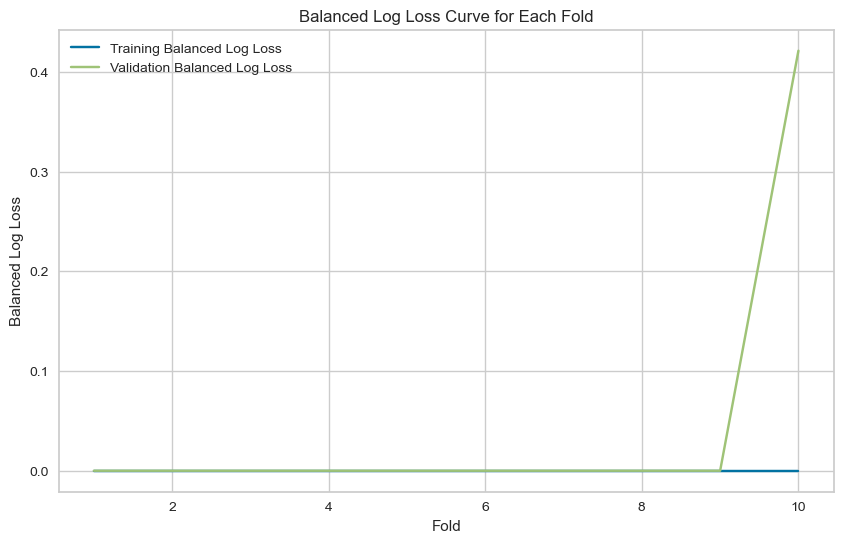

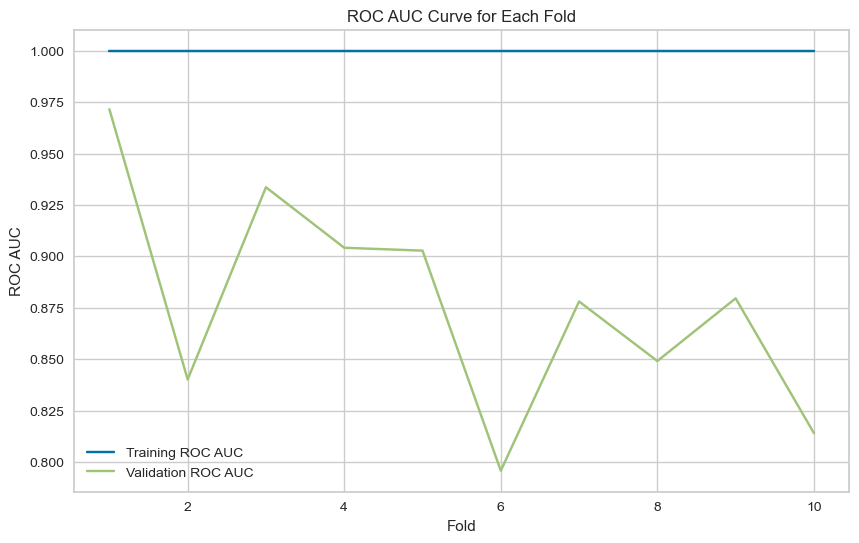

In [20]:
# Plotting roc_auc and balanced log loss for each fols

train_balanced_log_loss = scores['train_balanced_log_loss']
val_balanced_log_loss = scores['test_balanced_log_loss']
train_roc_auc = scores['train_roc_auc']
val_roc_auc = scores['test_roc_auc']

# Get the number of folds
num_folds = len(train_balanced_log_loss)

# Create an array with the fold numbers (1 to num_folds)
fold_numbers = np.arange(1, num_folds + 1)

# Plot balanced log loss curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_balanced_log_loss, label='Training Balanced Log Loss')
plt.plot(fold_numbers, val_balanced_log_loss, label='Validation Balanced Log Loss')
plt.xlabel('Fold')
plt.ylabel('Balanced Log Loss')
plt.title('Balanced Log Loss Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC AUC curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_roc_auc, label='Training ROC AUC')
plt.plot(fold_numbers, val_roc_auc, label='Validation ROC AUC')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

Evaluating the influence of a single hyperparameter: number of trees

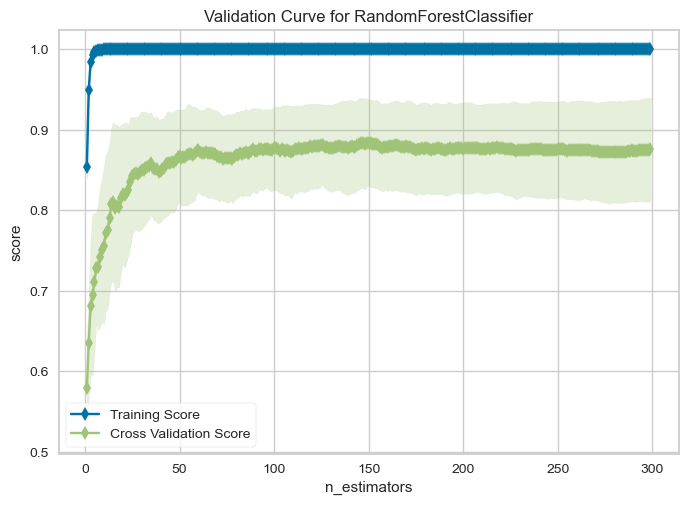

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [21]:
# Evaluate the validation curve on the number of trees
viz = ValidationCurve(rf, param_name="n_estimators", n_jobs=-1,
     param_range=np.arange(1, 300), cv=10, scoring="roc_auc")

viz.fit(X_train_pca, y_train)
viz.show()

Vizualize a sample tree

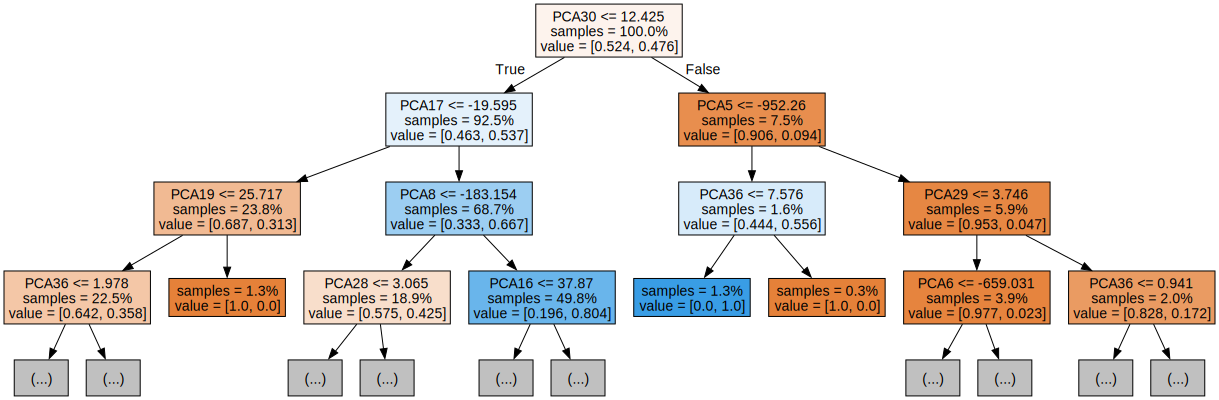

In [23]:
# Export the first decision tree from the forest
columns = [i for i in train_df_pca.columns if i not in ['Class']]


for i in range(1):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=columns,
                               filled=True,
                               max_depth=3, #show depth of tree. If None, shows full tree
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Fit the best model to whole training set after k-fold cross-validation

## Hyperparameter tuning
---

In [24]:
#hyperparameter tuning: 
hyperparameter_space = {'n_estimators': [100,200,300,500,1000], #number of trees default=100
                         'max_depth': [3, 6, 9]} #depth of trees


scoring_metrics = {
    'roc_auc': 'roc_auc',
    'balanced_log_loss': balanced_log_loss_scorer
}

# GridSearchCV for ROC AUC
gs_roc_auc = GridSearchCV(rf, param_grid=hyperparameter_space, cv=10, n_jobs=-1, scoring='roc_auc', refit='roc_auc')
gs_roc_auc.fit(X_train_pca, y_train)

# GridSearchCV for balanced log loss
gs_balanced_log_loss = GridSearchCV(rf, param_grid=hyperparameter_space, cv=10, n_jobs=-1, scoring=make_scorer(balanced_log_loss, greater_is_better=False), refit='balanced_log_loss')
gs_balanced_log_loss.fit(X_train_pca, y_train)

# Access the best models for each metric
best_model_roc_auc = gs_roc_auc.best_estimator_
best_model_balanced_log_loss = gs_balanced_log_loss.best_estimator_

# Access the best hyperparameters for each metric
best_params_roc_auc = gs_roc_auc.best_params_
best_params_balanced_log_loss = gs_balanced_log_loss.best_params_

In [25]:
print("Best model for roc_auc: ", best_model_roc_auc)
print("Best model for balanced log loss: ", best_model_balanced_log_loss)

print("Optimal hyperparameter combination for roc_auc: ", best_params_roc_auc)
print("Optimal hyperparameter combination for balanced log loss: ", best_params_balanced_log_loss)

Best model for roc_auc:  RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=9, n_estimators=1000,
                       oob_score=True, random_state=42)
Best model for balanced log loss:  RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=3, oob_score=True,
                       random_state=42)
Optimal hyperparameter combination for roc_auc:  {'max_depth': 9, 'n_estimators': 1000}
Optimal hyperparameter combination for balanced log loss:  {'max_depth': 3, 'n_estimators': 100}


## Fit best model
---

In [26]:
# the best model in terms of log loss was selected 
best_model = RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=3, oob_score=True,
                       random_state=42)

best_model.fit(X_train_pca, y_train)

RandomForestClassifier(class_weight={0: 2.9, 1: 0.6041666666666666},
                       criterion='entropy', max_depth=3, oob_score=True,
                       random_state=42)

## Evaluate best model
---

In [27]:
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False)

scoring = {
    'roc_auc': 'roc_auc',
    'balanced_log_loss': balanced_log_loss_scorer
}

scores = cross_validate(best_model, X_train_pca, y_train, n_jobs=-1, cv=10, scoring=scoring, return_train_score=True)
sorted(scores.keys())

# Training and validation balanced Log Loss
print("Training balanced log loss. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_balanced_log_loss'].mean(),scores['train_balanced_log_loss'].std()))
print("Validation balanced log loss. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_balanced_log_loss'].mean(),scores['test_balanced_log_loss'].std()))

print("-"*50)
# Training and validation average roc_auc
print("Training balanced roc_auc. Mean: %0.2f, Standard deviation: %0.2f" % (scores['train_roc_auc'].mean(),scores['train_roc_auc'].std()))
print("Validation balanced roc_auc. Mean: %0.2f Standard deviation: %0.2f" % (scores['test_roc_auc'].mean(),scores['test_roc_auc'].std()))

Training balanced log loss. Mean: 0.32, Standard deviation: 0.10
Validation balanced log loss. Mean: 1.06 Standard deviation: 0.63
--------------------------------------------------
Training balanced roc_auc. Mean: 0.98, Standard deviation: 0.00
Validation balanced roc_auc. Mean: 0.86 Standard deviation: 0.08


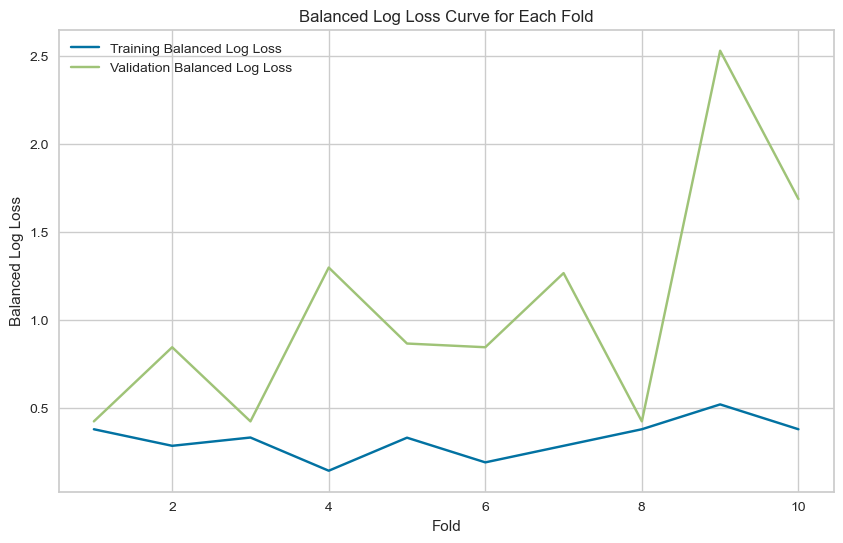

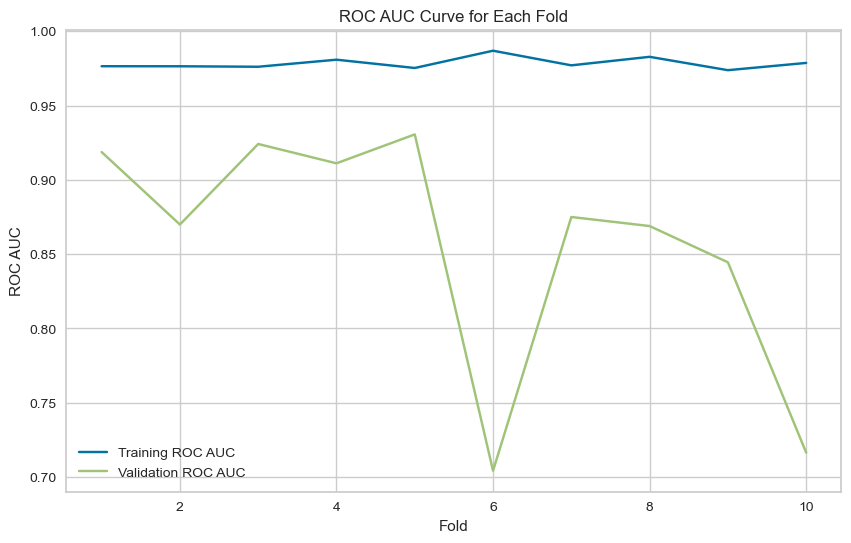

In [28]:
train_balanced_log_loss = scores['train_balanced_log_loss']
val_balanced_log_loss = scores['test_balanced_log_loss']
train_roc_auc = scores['train_roc_auc']
val_roc_auc = scores['test_roc_auc']

# Get the number of folds
num_folds = len(train_balanced_log_loss)

# Create an array with the fold numbers (1 to num_folds)
fold_numbers = np.arange(1, num_folds + 1)

# Plot balanced log loss curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_balanced_log_loss, label='Training Balanced Log Loss')
plt.plot(fold_numbers, val_balanced_log_loss, label='Validation Balanced Log Loss')
plt.xlabel('Fold')
plt.ylabel('Balanced Log Loss')
plt.title('Balanced Log Loss Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC AUC curves
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, train_roc_auc, label='Training ROC AUC')
plt.plot(fold_numbers, val_roc_auc, label='Validation ROC AUC')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Curve for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

Evaluating the influence of a single hyperparameter (number of trees) on roc_auc, for the best model

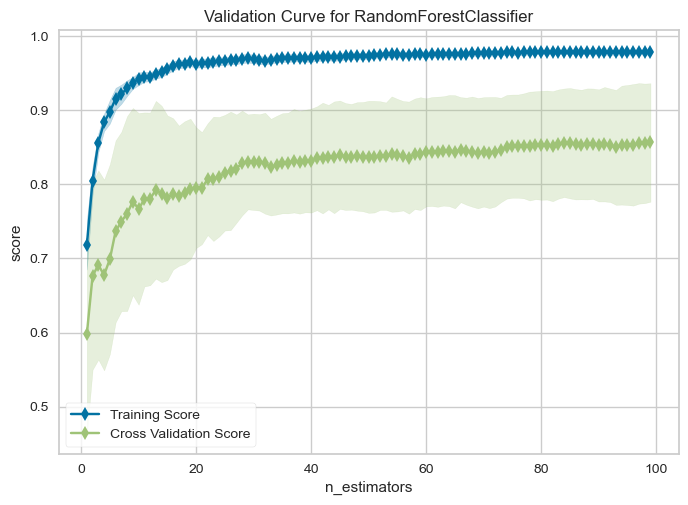

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [29]:
viz = ValidationCurve(best_model, param_name="n_estimators", n_jobs=-1,
     param_range=np.arange(1, 100), cv=10, scoring="roc_auc")

viz.fit(X_train_pca, y_train)
viz.show()

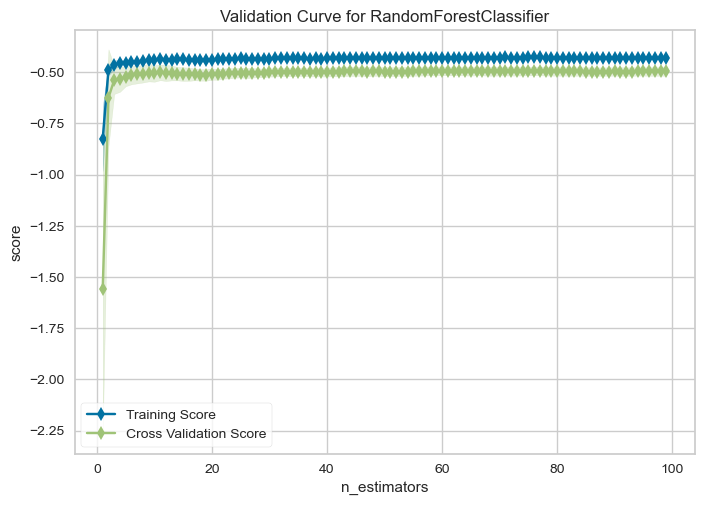

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [31]:
# the loss curve is inverted because decision trees deal with negative log losses
viz = ValidationCurve(best_model, param_name="n_estimators", n_jobs=-1,
     param_range=np.arange(1, 100), cv=10, scoring="neg_log_loss")

viz.fit(X_train_pca, y_train)
viz.show()

# Predict

----

In [34]:
# Generate predictions with the best model
y_pred = best_model.predict(X_test_pca)

print("MODEL ROC_AUC: ", roc_auc_score(y_test, y_pred))
print("MODEL LOG LOSS: ", balanced_log_loss(y_test, y_pred)) #comes out negative but the true value is positive because og how decision trees evaluate it

MODEL ROC_AUC:  0.7262160998708567
MODEL LOG LOSS:  -1.1968882909127465


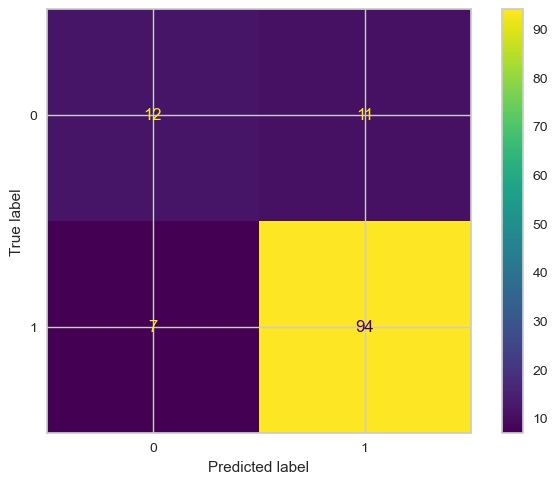

In [33]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Conclusions

---

1. Train, cross-validation and test valuest for the best model: 

||roc_auc|log_loss|
|---|---|---|
|Train|0.98|0.32|
|Validation|0.86|1.06|
|Test|0.72|1.19|


- Model only seems to be good at predicting the positive class (having any of the three medical conditions). This is useful in terms of what we want to accomplish, but it does a bad job at predicting when the patient has none of the medical condtiions.  


2. Next options: 
- Use other strategies to deal with class imbalance (downsampling)
